In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('./mnist/data/', one_hot=True)

Extracting ./mnist/data/train-images-idx3-ubyte.gz
Extracting ./mnist/data/train-labels-idx1-ubyte.gz
Extracting ./mnist/data/t10k-images-idx3-ubyte.gz
Extracting ./mnist/data/t10k-labels-idx1-ubyte.gz


In [3]:
total_epoch = 100
batch_size = 100
n_noise = 100

D_global_step = tf.Variable(0, trainable=False, name='D_global_step')
G_global_step = tf.Variable(0, trainable=False, name='G_global_step')

X = tf.placeholder(tf.float32, [None, 28, 28, 1])
Z = tf.placeholder(tf.float32, [None, n_noise])
is_training = tf.placeholder(tf.bool)

In [4]:
def generator(noise):
    with tf.variable_scope('generator'):
        output = tf.layers.dense(noise, 128*7*7)
        output = tf.reshape(output, [-1, 7, 7, 128])
        output = tf.nn.relu(tf.layers.batch_normalization(output, training=is_training))
        output = tf.layers.conv2d_transpose(output, 64, [5, 5], strides=(2, 2), padding='SAME')
        output = tf.nn.relu(tf.layers.batch_normalization(output, training=is_training))
        output = tf.layers.conv2d_transpose(output, 32, [5, 5], strides=(2, 2), padding='SAME')
        output = tf.nn.relu(tf.layers.batch_normalization(output, training=is_training))
        output = tf.layers.conv2d_transpose(output, 1, [5, 5], strides=(1,1), padding='SAME')
        output = tf.nn.tanh(output)
    return output

def discriminator(inputs, reuse=None):
    with tf.variable_scope('discriminator') as scope:
        if reuse:
            scope.reuse_variables()
#         output = tf.nn.leaky_relu(tf.layers.batch_normalization(inputs, training=is_training))
        output = tf.layers.conv2d(inputs, 32, [5,5],strides=(2,2),padding='SAME')
        output = tf.nn.leaky_relu(tf.layers.batch_normalization(output,training=is_training))
        output = tf.layers.conv2d(output, 64, [5,5], strides=(2,2),padding='SAME')
        output = tf.nn.leaky_relu(tf.layers.batch_normalization(output,training=is_training))
        output = tf.layers.conv2d(output, 128,[5,5], strides=(2,2), padding='SAME')
        output = tf.nn.leaky_relu(tf.layers.batch_normalization(output, training=is_training))
        flat = tf.contrib.layers.flatten(output)
        output = tf.layers.dense(flat, 1, activation=None)
    return output
                                           

In [5]:
def get_noise(batch_size, n_noise):
#     return np.random.normal(size=[batch_size, n_noise])
    return np.random.uniform(-1.0, 1.0, size=[batch_size, n_noise])

In [6]:
G = generator(Z)
D_real = discriminator(X)
D_gene = discriminator(G, True)

In [7]:
# loss_D = tf.reduce_mean(tf.log(D_real) + tf.log(1 - D_gene))
# loss_G = tf.reduce_mean(tf.log(D_gene))
loss_D_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
    logits=D_real, labels=tf.ones_like(D_real)
))
loss_D_gene = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
    logits=D_gene, labels=tf.zeros_like(D_gene)
))
 
loss_D = loss_D_real + loss_D_gene
loss_G = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
    logits=D_gene, labels=tf.ones_like(D_gene)
))

In [8]:
vars_D = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='discriminator')
vars_G = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='generator')

train_D = tf.train.AdamOptimizer().minimize(loss_D, var_list = vars_D, global_step=D_global_step)
train_G = tf.train.AdamOptimizer().minimize(loss_G, var_list = vars_G, global_step=G_global_step)

Epoch: 0000 D loss: 0.008081 G loss: 9.878
Epoch: 0004 D loss: 0.2167 G loss: 6.214
Epoch: 0009 D loss: 0.7379 G loss: 1.908
Epoch: 0014 D loss: 0.277 G loss: 2.715
Epoch: 0019 D loss: 0.5345 G loss: 3.181
Epoch: 0024 D loss: 0.4724 G loss: 2.866
Epoch: 0029 D loss: 1.264 G loss: 2.334
Epoch: 0034 D loss: 0.5366 G loss: 2.316
Epoch: 0039 D loss: 0.4901 G loss: 2.535
Epoch: 0044 D loss: 0.2936 G loss: 3.437
Epoch: 0049 D loss: 0.5471 G loss: 3.907
Epoch: 0054 D loss: 0.5368 G loss: 2.875
Epoch: 0059 D loss: 0.2165 G loss: 4.147
Epoch: 0064 D loss: 0.4065 G loss: 3.189
Epoch: 0069 D loss: 0.554 G loss: 4.678
Epoch: 0074 D loss: 0.3942 G loss: 2.339
Epoch: 0079 D loss: 0.197 G loss: 3.972
Epoch: 0084 D loss: 0.1989 G loss: 3.216
Epoch: 0089 D loss: 0.2201 G loss: 4.32
Epoch: 0094 D loss: 0.1327 G loss: 6.59
Epoch: 0099 D loss: 0.1722 G loss: 4.026


C:\Users\my\Anaconda3\envs\tf\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


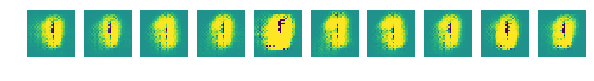

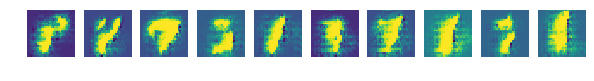

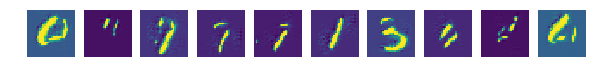

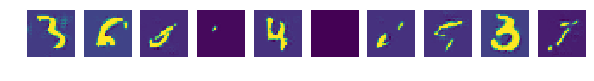

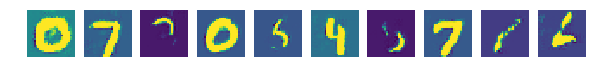

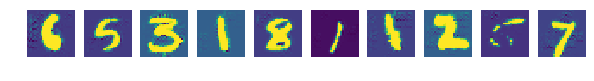

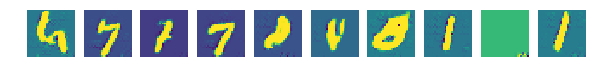

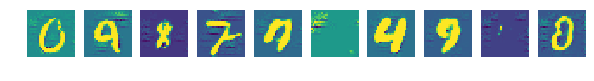

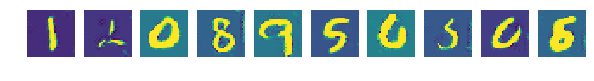

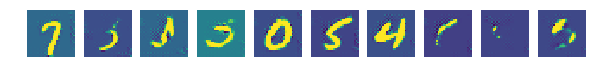

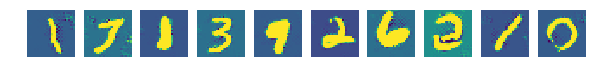

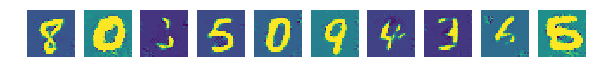

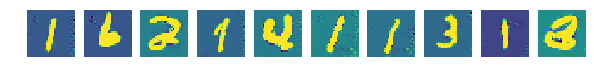

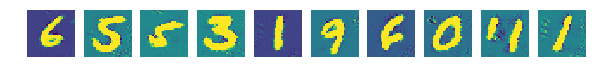

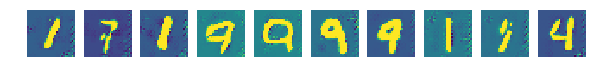

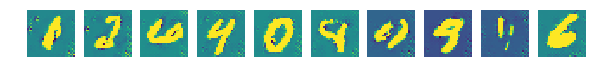

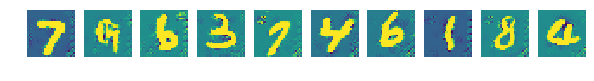

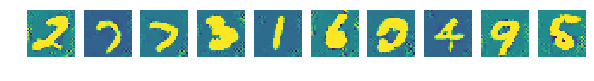

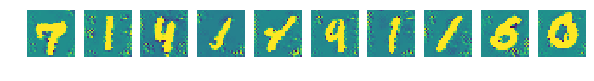

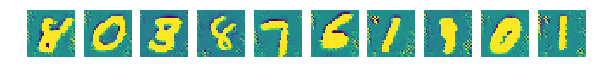

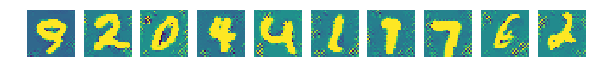

In [9]:
tf.summary.scalar('loss_D', loss_D)
tf.summary.scalar('loss_G', loss_G)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    merged = tf.summary.merge_all()
    writer = tf.summary.FileWriter('./DCGAN_logs', sess.graph)
    
    total_batch = int(mnist.train.num_examples / batch_size)
    
    for epoch in range(total_epoch):
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)
            batch_xs = batch_xs.reshape(-1, 28, 28, 1)
            noise = get_noise(batch_size, n_noise)

            _, loss_val_D = sess.run([train_D, loss_D], feed_dict={X:batch_xs, Z:noise, is_training:True})
            _, loss_val_G = sess.run([train_G, loss_G], feed_dict={Z:noise, is_training: True})
        
        summary = sess.run(merged, feed_dict={X:batch_xs, Z:noise, is_training:True})
        writer.add_summary(summary, global_step=sess.run(G_global_step))

        if epoch == 0 or (epoch + 1) % 5 == 0:
            print('Epoch:', '%04d'%epoch, 'D loss: {:.4}'.format(loss_val_D), 'G loss: {:.4}'.format(loss_val_G))
            sample_size = 10
            noise = get_noise(sample_size, n_noise)
            samples = sess.run(G, feed_dict={Z:noise, is_training:False})

            fig, ax = plt.subplots(1, sample_size, figsize=(sample_size, 1))
            for i in range(sample_size):
                ax[i].set_axis_off()
                ax[i].imshow(np.reshape(samples[i], (28, 28)))

            plt.savefig('./DCGAN_samples2/{}.png'.format(str(epoch).zfill(3)), bbox_inches='tight')